In [4]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor, einsum
from einops import parse_shape, rearrange, repeat
from PIL import Image

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


In [ ]:
class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

def get_image_tensor(sidelength):
    img = Image.open('stock.jpeg')        
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.Resize(sidelength),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img


class ImageFitting(torch.utils.data.Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img = get_image_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels
    
    
cameraman = ImageFitting(256)
dataloader = torch.utils.data.DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=64, 
                  hidden_layers=1, outermost_linear=True)


total_steps = 1000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-2, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))

for step in range(total_steps):
    model_output, coords = img_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

        fig, axes = plt.subplots(1,1, figsize=(6,6))
        axes.imshow(model_output.cpu().view(256,256).detach().numpy(), cmap='gray')
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

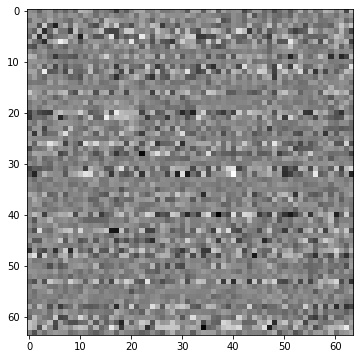

In [43]:
fig, axes = plt.subplots(1,1, figsize=(6,6))
axes.imshow(img_siren.net[1].linear.weight.detach().numpy(), cmap='gray')


In [38]:
import numpy as np
import torch.nn as nn
import torch
import math
import torch.nn.functional as F

class Sine(nn.Module):
    """Sine Activation Function."""

    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(30. * x)

def first_layer_film_sine_init(m):
    with torch.no_grad():
        if isinstance(m, nn.Linear):
            num_input = m.weight.size(-1)
            m.weight.uniform_(-1 / num_input, 1 / num_input)

def kaiming_leaky_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        torch.nn.init.kaiming_normal_(m.weight, a=0.2, mode='fan_in', nonlinearity='leaky_relu')

class CustomMappingNetwork(nn.Module):
    def __init__(self, z_dim, map_hidden_dim, map_output_dim):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(z_dim, map_hidden_dim),
                                     nn.LeakyReLU(0.2, inplace=True),

                                    nn.Linear(map_hidden_dim, map_hidden_dim),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    nn.Linear(map_hidden_dim, map_hidden_dim),
                                    nn.LeakyReLU(0.2, inplace=True),

                                    nn.Linear(map_hidden_dim, map_output_dim))

        self.network.apply(kaiming_leaky_init)
        with torch.no_grad():
            self.network[-1].weight *= 0.25

    def forward(self, z):
        frequencies_offsets = self.network(z)
        print(frequencies_offsets.shape)
        frequencies = frequencies_offsets[..., :frequencies_offsets.shape[-1]//2]
        phase_shifts = frequencies_offsets[..., frequencies_offsets.shape[-1]//2:]

        return frequencies, phase_shifts


def frequency_init(freq):
    def init(m):
        with torch.no_grad():
            if isinstance(m, nn.Linear):
                num_input = m.weight.size(-1)
                m.weight.uniform_(-np.sqrt(6 / num_input) / freq, np.sqrt(6 / num_input) / freq)
    return init

class FiLMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.layer = nn.Linear(input_dim, hidden_dim)

    def forward(self, x, freq, phase_shift):
        x = self.layer(x)
        freq = freq.unsqueeze(1).expand_as(x)
        phase_shift = phase_shift.unsqueeze(1).expand_as(x)
        return torch.sin(freq * x + phase_shift)


class TALLSIREN(nn.Module):
    """Primary SIREN  architecture used in pi-GAN generators."""

    def __init__(self, input_dim=2, z_dim=100, hidden_dim=256, output_dim=1, device=None):
        super().__init__()
        self.device = device
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.network = nn.ModuleList([
            FiLMLayer(input_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
            FiLMLayer(hidden_dim, hidden_dim),
        ])
        self.final_layer = nn.Linear(hidden_dim, 1)

        self.color_layer_sine = FiLMLayer(hidden_dim + 3, hidden_dim)
        self.color_layer_linear = nn.Sequential(nn.Linear(hidden_dim, 3), nn.Sigmoid())

        self.mapping_network = CustomMappingNetwork(z_dim, 256, (len(self.network) + 1)*hidden_dim*2)

        self.network.apply(frequency_init(25))
        self.final_layer.apply(frequency_init(25))
        self.color_layer_sine.apply(frequency_init(25))
        self.color_layer_linear.apply(frequency_init(25))
        self.network[0].apply(first_layer_film_sine_init)

    def forward(self, input, z, ray_directions, **kwargs):
        frequencies, phase_shifts = self.mapping_network(z)
        return self.forward_with_frequencies_phase_shifts(input, frequencies, phase_shifts, ray_directions, **kwargs)

    def forward_with_frequencies_phase_shifts(self, input, frequencies, phase_shifts, ray_directions, **kwargs):
        frequencies = frequencies*15 + 30

        x = input

        for index, layer in enumerate(self.network):
            start = index * self.hidden_dim
            end = (index+1) * self.hidden_dim
            x = layer(x, frequencies[..., start:end], phase_shifts[..., start:end])

        sigma = self.final_layer(x)
        rbg = self.color_layer_sine(torch.cat([ray_directions, x], dim=-1), frequencies[..., -self.hidden_dim:], phase_shifts[..., -self.hidden_dim:])
        rbg = self.color_layer_linear(rbg)

        return torch.cat([rbg, sigma], dim=-1)



In [39]:
hidden_dim = 256
length = 16

z = torch.randn((26, hidden_dim))
z

mapping_network = CustomMappingNetwork(hidden_dim, hidden_dim, (length + 1)*hidden_dim*2)
out = mapping_network(z)
print(out[0].shape, out[1].shape)

torch.Size([26, 8704])
torch.Size([26, 4352]) torch.Size([26, 4352])


In [30]:
import math

def normalize_vecs(vectors: torch.Tensor) -> torch.Tensor:
    """
    Normalize vector lengths.
    """
    return vectors / (torch.norm(vectors, dim=-1, keepdim=True))


def get_initial_rays_trig(n, num_steps, device, fov, resolution, ray_start, ray_end):
    """Returns sample points, z_vals, and ray directions in camera space."""

    W, H = resolution
    # Create full screen NDC (-1 to +1) coords [x, y, 0, 1].
    # Y is flipped to follow image memory layouts.
    x, y = torch.meshgrid(torch.linspace(-1, 1, W, device=device),
                          torch.linspace(1, -1, H, device=device))
    x = x.T.flatten()
    y = y.T.flatten()
    z = -torch.ones_like(x, device=device) / np.tan((2 * math.pi * fov / 360)/2)

    rays_d_cam = normalize_vecs(torch.stack([x, y, z], -1))


    z_vals = torch.linspace(ray_start, ray_end, num_steps, device=device).reshape(1, num_steps, 1).repeat(W*H, 1, 1)
    points = rays_d_cam.unsqueeze(1).repeat(1, num_steps, 1) * z_vals

    points = torch.stack(n*[points])
    z_vals = torch.stack(n*[z_vals])
    rays_d_cam = torch.stack(n*[rays_d_cam]).to(device)

    return points, z_vals, rays_d_cam


points_cam, z_vals, rays_d_cam = get_initial_rays_trig(n=10, num_steps=20, device='cpu', fov=12, resolution=(8, 8), ray_start=0.88, ray_end=1.12)

# Note: all points are in camera space:
# Points: all points of all rays: (b, h*w, steps, coord)
# Z-vals: all distances form start pixel for all rays: (b, h*w, steps, dist) interpolated from ray_start->ray_end
# Rays-d cam: all d starting points for each pixel (b, h*w, dir)

print(points.shape, z_vals.shape, rays_d_cam.shape)
#print(rays_d_cam[0])
print(z_vals[0][0])


def perturb_points(points, z_vals, ray_directions, device):
    distance_between_points = z_vals[:,:,1:2,:] - z_vals[:,:,0:1,:]
    offset = (torch.rand(z_vals.shape, device=device)-0.5) * distance_between_points
    z_vals = z_vals + offset

    points = points + offset * ray_directions.unsqueeze(2)
    return points, z_vals

def sample_camera_positions(device, n=1, r=1, horizontal_stddev=1, vertical_stddev=1, horizontal_mean=math.pi*0.5, vertical_mean=math.pi*0.5, mode='normal'):
    """
    Samples n random locations along a sphere of radius r. Uses the specified distribution.
    Theta is yaw in radians (-pi, pi)
    Phi is pitch in radians (0, pi)
    """

    if mode == 'uniform':
        theta = (torch.rand((n, 1), device=device) - 0.5) * 2 * horizontal_stddev + horizontal_mean
        phi = (torch.rand((n, 1), device=device) - 0.5) * 2 * vertical_stddev + vertical_mean

    elif mode == 'normal' or mode == 'gaussian':
        theta = torch.randn((n, 1), device=device) * horizontal_stddev + horizontal_mean
        phi = torch.randn((n, 1), device=device) * vertical_stddev + vertical_mean

    elif mode == 'hybrid':
        if random.random() < 0.5:
            theta = (torch.rand((n, 1), device=device) - 0.5) * 2 * horizontal_stddev * 2 + horizontal_mean
            phi = (torch.rand((n, 1), device=device) - 0.5) * 2 * vertical_stddev * 2 + vertical_mean
        else:
            theta = torch.randn((n, 1), device=device) * horizontal_stddev + horizontal_mean
            phi = torch.randn((n, 1), device=device) * vertical_stddev + vertical_mean

    elif mode == 'truncated_gaussian':
        theta = truncated_normal_(torch.zeros((n, 1), device=device)) * horizontal_stddev + horizontal_mean
        phi = truncated_normal_(torch.zeros((n, 1), device=device)) * vertical_stddev + vertical_mean

    elif mode == 'spherical_uniform':
        theta = (torch.rand((n, 1), device=device) - .5) * 2 * horizontal_stddev + horizontal_mean
        v_stddev, v_mean = vertical_stddev / math.pi, vertical_mean / math.pi
        v = ((torch.rand((n,1), device=device) - .5) * 2 * v_stddev + v_mean)
        v = torch.clamp(v, 1e-5, 1 - 1e-5)
        phi = torch.arccos(1 - 2 * v)

    else:
        # Just use the mean.
        theta = torch.ones((n, 1), device=device, dtype=torch.float) * horizontal_mean
        phi = torch.ones((n, 1), device=device, dtype=torch.float) * vertical_mean

    phi = torch.clamp(phi, 1e-5, math.pi - 1e-5)

    output_points = torch.zeros((n, 3), device=device)
    output_points[:, 0:1] = r*torch.sin(phi) * torch.cos(theta)
    output_points[:, 2:3] = r*torch.sin(phi) * torch.sin(theta)
    output_points[:, 1:2] = r*torch.cos(phi)

    return output_points, phi, theta

def create_cam2world_matrix(forward_vector, origin, device=None):
    """Takes in the direction the camera is pointing and the camera origin and returns a cam2world matrix."""

    forward_vector = normalize_vecs(forward_vector)
    up_vector = torch.tensor([0, 1, 0], dtype=torch.float, device=device).expand_as(forward_vector)

    left_vector = normalize_vecs(torch.cross(up_vector, forward_vector, dim=-1))

    up_vector = normalize_vecs(torch.cross(forward_vector, left_vector, dim=-1))

    rotation_matrix = torch.eye(4, device=device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    rotation_matrix[:, :3, :3] = torch.stack((-left_vector, up_vector, -forward_vector), axis=-1)

    translation_matrix = torch.eye(4, device=device).unsqueeze(0).repeat(forward_vector.shape[0], 1, 1)
    translation_matrix[:, :3, 3] = origin

    cam2world = translation_matrix @ rotation_matrix

    return cam2world

def transform_sampled_points(points, z_vals, ray_directions, device, h_stddev=1, v_stddev=1, h_mean=math.pi * 0.5, v_mean=math.pi * 0.5, mode='normal'):
    """Samples a camera position and maps points in camera space to world space."""

    n, num_rays, num_steps, channels = points.shape

    points, z_vals = perturb_points(points, z_vals, ray_directions, device)


    camera_origin, pitch, yaw = sample_camera_positions(n=points.shape[0], r=1, horizontal_stddev=h_stddev, vertical_stddev=v_stddev, horizontal_mean=h_mean, vertical_mean=v_mean, device=device, mode=mode)
    forward_vector = normalize_vecs(-camera_origin)

    cam2world_matrix = create_cam2world_matrix(forward_vector, camera_origin, device=device)

    points_homogeneous = torch.ones((points.shape[0], points.shape[1], points.shape[2], points.shape[3] + 1), device=device)
    points_homogeneous[:, :, :, :3] = points

    # should be n x 4 x 4 , n x r^2 x num_steps x 4
    transformed_points = torch.bmm(cam2world_matrix, points_homogeneous.reshape(n, -1, 4).permute(0,2,1)).permute(0, 2, 1).reshape(n, num_rays, num_steps, 4)


    transformed_ray_directions = torch.bmm(cam2world_matrix[..., :3, :3], ray_directions.reshape(n, -1, 3).permute(0,2,1)).permute(0, 2, 1).reshape(n, num_rays, 3)

    homogeneous_origins = torch.zeros((n, 4, num_rays), device=device)
    homogeneous_origins[:, 3, :] = 1
    transformed_ray_origins = torch.bmm(cam2world_matrix, homogeneous_origins).permute(0, 2, 1).reshape(n, num_rays, 4)[..., :3]

    return transformed_points[..., :3], z_vals, transformed_ray_directions, transformed_ray_origins, pitch, yaw


transformed_points, z_vals, transformed_ray_directions, transformed_ray_origins, pitch, yaw = transform_sampled_points(points_cam, z_vals, rays_d_cam, h_stddev=0.3, v_stddev=0.155, h_mean=math.pi*0.5, v_mean=math.pi*0.5, device='cpu', mode='gaussian')

print(transformed_points.shape, z_vals.shape, transformed_ray_directions.shape, transformed_ray_origins.shape, pitch.shape, yaw.shape)

print(rays_d_cam[0][0])



torch.Size([10, 64, 20, 3]) torch.Size([10, 64, 20, 1]) torch.Size([10, 64, 3])
tensor([[0.8800],
        [0.8926],
        [0.9053],
        [0.9179],
        [0.9305],
        [0.9432],
        [0.9558],
        [0.9684],
        [0.9811],
        [0.9937],
        [1.0063],
        [1.0189],
        [1.0316],
        [1.0442],
        [1.0568],
        [1.0695],
        [1.0821],
        [1.0947],
        [1.1074],
        [1.1200]])
torch.Size([10, 64, 20, 3]) torch.Size([10, 64, 20, 1]) torch.Size([10, 64, 3]) torch.Size([10, 64, 3]) torch.Size([10, 1]) torch.Size([10, 1])
tensor([-0.1040,  0.1040, -0.9891])
tensor([-0.2465, -0.0646, -0.9670])


In [ ]:


class ImplicitGenerator3d(nn.Module):
    def __init__(self, siren, z_dim, **kwargs):
        super().__init__()
        self.z_dim = z_dim
        self.siren = TALLSIREN(output_dim=4, z_dim=self.z_dim, input_dim=3, device=None)
        self.epoch = 0
        self.step = 0

    def set_device(self, device):
        self.device = device
        self.siren.device = device

        self.generate_avg_frequencies()

    def forward(self, z, img_size, fov, ray_start, ray_end, num_steps, h_stddev, v_stddev, h_mean, v_mean, hierarchical_sample, sample_dist=None, lock_view_dependence=False, **kwargs):
        """
        Generates images from a noise vector, rendering parameters, and camera distribution.
        Uses the hierarchical sampling scheme described in NeRF.
        """

        batch_size = z.shape[0]

        # Generate initial camera rays and sample points.
        with torch.no_grad():
            points_cam, z_vals, rays_d_cam = get_initial_rays_trig(batch_size, num_steps, resolution=(img_size, img_size), device=self.device, fov=fov, ray_start=ray_start, ray_end=ray_end) # batch_size, pixels, num_steps, 1
            transformed_points, z_vals, transformed_ray_directions, transformed_ray_origins, pitch, yaw = transform_sampled_points(points_cam, z_vals, rays_d_cam, h_stddev=h_stddev, v_stddev=v_stddev, h_mean=h_mean, v_mean=v_mean, device=self.device, mode=sample_dist)

            transformed_ray_directions_expanded = torch.unsqueeze(transformed_ray_directions, -2)
            transformed_ray_directions_expanded = transformed_ray_directions_expanded.expand(-1, -1, num_steps, -1)
            transformed_ray_directions_expanded = transformed_ray_directions_expanded.reshape(batch_size, img_size*img_size*num_steps, 3)
            transformed_points = transformed_points.reshape(batch_size, img_size*img_size*num_steps, 3)

            if lock_view_dependence:
                transformed_ray_directions_expanded = torch.zeros_like(transformed_ray_directions_expanded)
                transformed_ray_directions_expanded[..., -1] = -1
 
        # Model prediction on course points
        coarse_output = self.siren(transformed_points, z, ray_directions=transformed_ray_directions_expanded).reshape(batch_size, img_size * img_size, num_steps, 4)

        # Re-sample fine points along camera rays, as described in NeRF
        if hierarchical_sample:
            with torch.no_grad():
                transformed_points = transformed_points.reshape(batch_size, img_size * img_size, num_steps, 3)
                _, _, weights = fancy_integration(coarse_output, z_vals, device=self.device, clamp_mode=kwargs['clamp_mode'], noise_std=kwargs['nerf_noise'])

                weights = weights.reshape(batch_size * img_size * img_size, num_steps) + 1e-5

                #### Start new importance sampling
                z_vals = z_vals.reshape(batch_size * img_size * img_size, num_steps)
                z_vals_mid = 0.5 * (z_vals[: ,:-1] + z_vals[: ,1:])
                z_vals = z_vals.reshape(batch_size, img_size * img_size, num_steps, 1)
                fine_z_vals = sample_pdf(z_vals_mid, weights[:, 1:-1],
                                 num_steps, det=False).detach()
                fine_z_vals = fine_z_vals.reshape(batch_size, img_size * img_size, num_steps, 1)


                fine_points = transformed_ray_origins.unsqueeze(2).contiguous() + transformed_ray_directions.unsqueeze(2).contiguous() * fine_z_vals.expand(-1,-1,-1,3).contiguous()
                fine_points = fine_points.reshape(batch_size, img_size*img_size*num_steps, 3)

                if lock_view_dependence:
                    transformed_ray_directions_expanded = torch.zeros_like(transformed_ray_directions_expanded)
                    transformed_ray_directions_expanded[..., -1] = -1
                #### end new importance sampling

            # Model prediction on re-sampled find points
            fine_output = self.siren(fine_points, z, ray_directions=transformed_ray_directions_expanded).reshape(batch_size, img_size * img_size, -1, 4)

            # Combine course and fine points
            all_outputs = torch.cat([fine_output, coarse_output], dim = -2)
            all_z_vals = torch.cat([fine_z_vals, z_vals], dim = -2)
            _, indices = torch.sort(all_z_vals, dim=-2)
            all_z_vals = torch.gather(all_z_vals, -2, indices)
            all_outputs = torch.gather(all_outputs, -2, indices.expand(-1, -1, -1, 4))
        else:
            all_outputs = coarse_output
            all_z_vals = z_vals


        # Create images with NeRF
        pixels, depth, weights = fancy_integration(all_outputs, all_z_vals, device=self.device, white_back=kwargs.get('white_back', False), last_back=kwargs.get('last_back', False), clamp_mode=kwargs['clamp_mode'], noise_std=kwargs['nerf_noise'])

        pixels = pixels.reshape((batch_size, img_size, img_size, 3))
        pixels = pixels.permute(0, 3, 1, 2).contiguous() * 2 - 1

        return pixels, torch.cat([pitch, yaw], -1)
    
    
    def generate_avg_frequencies(self):
        """Calculates average frequencies and phase shifts"""

        z = torch.randn((10000, self.z_dim), device=self.siren.device)
        with torch.no_grad():
            frequencies, phase_shifts = self.siren.mapping_network(z)
        self.avg_frequencies = frequencies.mean(0, keepdim=True)
        self.avg_phase_shifts = phase_shifts.mean(0, keepdim=True)
        return self.avg_frequencies, self.avg_phase_shifts

